In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets

In [3]:
import pandas as pd

In [4]:
import theano

Using gpu device 0: GeForce GTX 980 Ti (CNMeM is enabled with initial size: 70.0% of memory, cuDNN 5105)
/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


I accomplished the above by running this command at the command prompt:   

```    
THEANO_FLAGS='mode=FAST_RUN,device=gpu,floatX=float32' jupyter notebook   
```


In [5]:
#import theano
from theano import function, config, sandbox, shared 
import theano.tensor as T
import numpy as np
import scipy
import time

## More `theano` setup in `jupyter` notebook boilerplate

In [6]:
print( theano.config.device )
print( theano.config.lib.cnmem)  # cf. http://deeplearning.net/software/theano/library/config.html
print( theano.config.print_active_device)# Print active device at when the GPU device is initialized.

gpu0
0.7
True


In [7]:
import os, sys
os.getcwd()
os.listdir( os.getcwd() ) 

['LogReg-sklearn.ipynb',
 'Linear Algebra Shootout: NumPy vs. Theano vs. TensorFlow_files',
 'LICENSE',
 'theano.pdf',
 'deeplearning.pdf',
 'sklearn_ML.ipynb',
 'LaTeXandpdfs',
 'supervised-theano.ipynb',
 'sanity_check_theano_uses_gpu.ipynb',
 '.git',
 'README.md',
 'Linear Algebra Shootout: NumPy vs. Theano vs. TensorFlow.html',
 '.ipynb_checkpoints',
 'theano_ML.ipynb',
 'deep-learning--ud730',
 'tf_sanitycheck.ipynb',
 'FedoraNVidiaInstallTips',
 'tf',
 'kaggle',
 'ML',
 'sampleinputdataX_sklearn.ipynb',
 'Data',
 'simple_logreg.py',
 'Speeding up your Neural Network with Theano and the GPU \xe2\x80\x93 WildML_files',
 'coursera_Ng',
 'MorseTheory.ipynb',
 'tutorial_theano.ipynb',
 'best_model.pkl',
 'gpu_test.py',
 'Speeding up your Neural Network with Theano and the GPU \xe2\x80\x93 WildML.html']

In [8]:
%run gpu_test.py THEANO_FLAGS='mode=FAST_RUN,device=gpu,floatX=float32,lib.cnmem=0.85' # note lib.cnmem option for CnMem

[GpuElemwise{exp,no_inplace}(<CudaNdarrayType(float32, vector)>), HostFromGpu(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.197625 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


# sample data boilerplate

In [9]:
# Load the diabetes dataset
diabetes = sklearn.datasets.load_diabetes()

In [10]:
diabetes_X = diabetes.data
diabetes_Y = diabetes.target

In [11]:
#diabetes_X1 = diabetes_X[:,np.newaxis,2]
diabetes_X1 = diabetes_X[:,np.newaxis, 2].astype(theano.config.floatX)
#diabetes_Y  = diabetes_Y.reshape( diabetes_Y.shape[0], 1)
diabetes_Y = diabetes_Y.astype(theano.config.floatX)

# Linear regression

cf. [Linear Regression In Theano](https://roshansanthosh.wordpress.com/2015/02/22/linear-regression-in-theano/)

[`1_linear_regression.py` from `github` Newmu/Theano-Tutorials](https://github.com/Newmu/Theano-Tutorials/blob/master/1_linear_regression.py)

Train on $m$ number of input data points

In [12]:
m_lin = diabetes_X1.shape[0]

### input, output variables $x$, $y$ for Theano

In [28]:
#x1 = T.vector('x1')  # X1, input data, with only 1 feature, i.e. X \in \mathbb{R}^N, d=1 
#ylin = T.vector('ylin') # target variable for linear regression, so that Y \in \mathbb{R}

x1 = T.scalar('x1')  # X1, input data, with only 1 feature, i.e. X \in \mathbb{R}^N, d=1 
ylin = T.scalar('ylin') # target variable for linear regression, so that Y \in \mathbb{R}

### Parameters (for a linear slope)  

$$    
(\theta^0, \theta^1) \in \mathbb{R}^2   
$$

In [29]:
thet0_init_val = np.random.randn()
thet1_init_val = np.random.randn()

In [30]:
thet0 = theano.shared( value=thet0_init_val, name='thet0', borrow=True)  # \theta^0
thet1 = theano.shared( thet1_init_val, name='thet1', borrow=True)   # \theta^1


### hypothesis function $h_{\theta}$

$$   
h_{\theta}(x) = \theta_1 x + \theta_0
$$

In [31]:
#h_thet = T.dot( thet1, x1) + thet0
# whereas, Newmu uses
h_thet = thet1 * x1 + thet0

### Cost function $J(\theta)$

In [32]:
# roshansanthosh uses 
#Jthet = T.sum( T.pow(h_thet-ylin,2))/(2*m_lin)

# whereas, Newmu uses
# Jthet = T.mean( T.sqr( thet_1*x1 + thet_0 - ylin ))

Jthet = T.mean( T.pow( h_thet-ylin,2))/2
#Jthet = sandbox.cuda.basic_ops.gpu_from_host( T.mean( 
#        sandbox.cuda.basic_ops.gpu_from_host( T.pow( h_thet-ylin,2))))/2

$$
\text{grad}_{\theta}J(\theta) = ( \text{grad}_{\theta^0} J , \text{grad}_{\theta^1} J )   
$$

In [33]:
grad_thet0 = T.grad(Jthet, thet0)
grad_thet1 = T.grad(Jthet, thet1)


In [19]:
# so-called "learning rate"
gamma = 0.01

Note that "**updates** (iterable over pairs (shared_variable, new_expression) List, tuple or dict.) – expressions for new SharedVariable values" cf. [Theano doc](http://deeplearning.net/software/theano/library/compile/function.html)

In [34]:
train_lin = theano.function(inputs = [x1,ylin], outputs=Jthet, 
                        updates=[[thet1,thet1-gamma*grad_thet1],[thet0,thet0-gamma*grad_thet0]])



In [35]:
test_lin = theano.function([x1],h_thet)

In [100]:
#X1_lin_in = shared( diabetes_X1 ,'float32')
#Y_lin_out = shared( diabetes_Y, 'float32')

In [23]:
training_steps = 1000 # 10000

In [36]:
sh_diabetes_X1 = shared( diabetes_X1 , borrow=True)
sh_diabetes_Y  = shared( diabetes_Y, borrow=True)

In [37]:
"""
for i in range(training_steps):
    for x,y in zip( diabetes_X1, diabetes_Y):
        Jthet_val = train_lin( x, y )
        """

for i in range(training_steps):
#    for x,y in zip( sh_diabetes_X1, sh_diabetes_Y) :
#        Jthet_val = train_lin( x,y)
    Jthet_val = train_lin( sh_diabetes_X1, sh_diabetes_Y)

TypeError: ('Bad input argument to theano function with name "<ipython-input-34-92f3da11396a>:2"  at index 0(0-based)', 'Expected an array-like object, but found a Variable: maybe you are trying to call a function on a (possibly shared) variable instead of a numeric array?')

In [27]:
print(Jthet_val)

NameError: name 'Jthet_val' is not defined

In [129]:
print( thet0.get_value() ); print( thet1.get_value() )



151.746080721
942.701275851


In [134]:
test_lin_out = np.array( [ test_lin( x ) for x in diabetes_X1 ] ) 

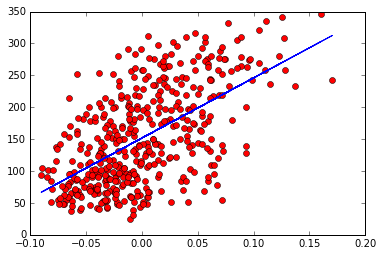

In [137]:
plt.plot(diabetes_X1,diabetes_Y,'ro')
plt.plot(diabetes_X1,test_lin_out)

In [38]:
if any([x.op.__class__.__name__ in ['GpuGemm','GpuGemv'] for x in train_lin.maker.fgraph.toposort()]):
    print("Used the gpu")
else:
    print(train_lin.maker.fgraph.toposort())

[Elemwise{Composite{(((i0 * i1) + i2) - i3)}}(thet1, x1, thet0, ylin), Elemwise{Composite{(i0 - (i1 * i2))}}[(0, 0)](thet0, TensorConstant{0.00999999977648}, Elemwise{Composite{(((i0 * i1) + i2) - i3)}}.0), Elemwise{Composite{(i0 - (i1 * i2 * i3))}}[(0, 0)](thet1, TensorConstant{0.00999999977648}, Elemwise{Composite{(((i0 * i1) + i2) - i3)}}.0, x1), Elemwise{Composite{(i0 * sqr(i1))}}[(0, 1)](TensorConstant{0.5}, Elemwise{Composite{(((i0 * i1) + i2) - i3)}}.0)]


In [39]:
if np.any([isinstance(x.op,T.Elemwise) for x in train_lin.maker.fgraph.toposort()]):
    print("Used the cpu")

Used the cpu


## Linear Algebra and `theano`

cf. [Week 1, Linear Algebra Review, Coursera, Machine Learning with Ng](https://www.coursera.org/learn/machine-learning/lecture/38jIT/matrices-and-vectors)

I'll take this opportunity to provide a dictionary between the syntax of linear algebra math and `numpy`.   

Essentially, what I did was take Coursera's [Week 1, Linear Algebra Review](https://www.coursera.org/learn/machine-learning/lecture/dpF1j/matrix-matrix-multiplication) and then translated the math into **`theano`**, and in particular, running theano on the **GPU**.

Other reference that I used was 

https://simplyml.com/linear-algebra-shootout-numpy-vs-theano-vs-tensorflow-2/

[Linear Algebra Shootout: NumPy vs. Theano vs. TensorFlow by Charanpal Dhanjal - 14/07/16 ](https://simplyml.com/linear-algebra-shootout-numpy-vs-theano-vs-tensorflow-2/)

#### Matrix addition

cf. [Coursera, Intro. to Machine Learning, Linear Algebra Review, Addition and Scalar Multiplication](https://www.coursera.org/learn/machine-learning/lecture/R4hiJ/addition-and-scalar-multiplication)

In [69]:
A = T.matrix('A')
B = T.matrix('B')
#matadd = function([A,B], A+B)
#matadd = function([A,B],sandbox.cuda.basic_ops.gpu_from_host(A+B) )
# Note: we are just defining the expressions, nothing is evaluated here!  
C = sandbox.cuda.basic_ops.gpu_from_host(A+B)
matadd = function([A,B], C)

In [121]:
#A = T.dmatrix('A')
#B = T.dmatrix('B')

A = T.matrix('A')
B = T.matrix('B')

C_out = A + B
matadd_CPU = function([A,B], C_out)

In [73]:
A_eg = shared( np.array([[8,6,9],[10,1,10]]), 'float32')
B_eg = shared( np.array([[3,10,2],[6,1,-1]]), 'float32')


In [85]:
A_eg_CPU = np.array([[8,6,9],[10,1,10]])
B_eg_CPU = np.array([[3,10,2],[6,1,-1]])

In [96]:
print(A_eg_CPU)
print( type( A_eg_CPU ))
print( A_eg_CPU.shape)
print( B_eg_CPU.shape)

[[ 8  6  9]
 [10  1 10]]
<type 'numpy.ndarray'>
(2, 3)
(2, 3)


In [70]:
print( matadd.maker.fgraph.toposort() )

[GpuFromHost(B), GpuFromHost(A), GpuElemwise{Add}[(0, 0)](GpuFromHost.0, GpuFromHost.0)]


In [122]:
print( matadd_CPU.maker.fgraph.toposort() )

[GpuFromHost(B), GpuFromHost(A), GpuElemwise{Add}[(0, 0)](GpuFromHost.0, GpuFromHost.0), HostFromGpu(GpuElemwise{Add}[(0, 0)].0)]


In [71]:
matadd( A_eg, B_eg)

TypeError: ('Bad input argument to theano function with name "<ipython-input-69-40293d053d65>:7"  at index 0(0-based)', 'Expected an array-like object, but found a Variable: maybe you are trying to call a function on a (possibly shared) variable instead of a numeric array?')

The way to do it, to "force" on the GPU, is like this (cf. [Speeding up your Neural Network with Theano and the GPU - Wild ML](http://www.wildml.com/2015/09/speeding-up-your-neural-network-with-theano-and-the-gpu/)):

In [76]:
np.random.randn( *A_eg_CPU.shape )

array([[ 1.01645633,  0.49394088, -0.22904526],
       [-0.44323914, -0.27948502,  0.335645  ]])

In [78]:
C_out = theano.shared( np.random.randn( *A_eg_CPU.shape).astype('float32') )

In [80]:
C_out.type()

<CudaNdarrayType(float32, matrix)>

In [110]:
#A_in = shared( A_eg_CPU, "float32")
#A_in = shared( A_eg_CPU, "float32")

A_in = shared( A_eg_CPU.astype("float32"), "float32")
B_in = shared( B_eg_CPU.astype("float32"), "float32")
#C_out_GPU = A_in + B_in
C_out_GPU = sandbox.cuda.basic_ops.gpu_from_host(A_in+B_in)


In [111]:
matadd_GPU = theano.function( [], C_out_GPU)

In [112]:
C_out_GPU_result = matadd_GPU()

In [113]:
C_out_GPU_result

CudaNdarray([[ 11.  16.  11.]
 [ 16.   2.   9.]])

Notice how **DIFFERENT** this setup or syntax is: we have to set up tensor or matrix *shared variables* `A_n`, `B_in`, which are then used to define the theano function, `theano.function`.  "By using shared variables we ensure that they are present in the GPU memory".  cf. [Linear Algebra Shootout: NumPy vs. Theano vs. TensorFlow](https://simplyml.com/linear-algebra-shootout-numpy-vs-theano-vs-tensorflow-2/)

In [114]:
print( matadd_GPU.maker.fgraph.toposort() )

[GpuElemwise{add,no_inplace}(float32, float32)]


In [128]:
#if np.any([isinstance(C_out_GPU.op, tensor.Elemwise ) and 
if np.any([isinstance( C_out_GPU.op, T.Elemwise ) and 
           ('Gpu' not in type( C_out_GPU.op).__name__) for x in matadd_GPU.maker.fgraph.toposort()]) :
    print('Used the cpu')
else:
    print('Used the gpu')

AttributeError: 'CudaNdarrayVariable' object has no attribute 'op'

In [124]:
matadd_CPU( A_eg_CPU.astype("float32"), B_eg_CPU.astype("float32") )

array([[ 11.,  16.,  11.],
       [ 16.,   2.,   9.]], dtype=float32)

In [55]:
type(A_eg)

theano.tensor.sharedvar.TensorSharedVariable

In [59]:
print( type( numpy.asarray(rng.rand(2000)) ) )
numpy.asarray(rng.rand(2000)).shape

<type 'numpy.ndarray'>


(2000,)

**Bottom Line:** there are **2** ways of doing linear algebra *on the GPU*

1. symbolic computation with the usual arguments    

$$
A + B = C \in \text{Mat}_{\mathbb{R}}(M,N)   
$$   

$ \forall \, A, B \in \text{Mat}_{\mathbb{R}}(M,N)$

In [132]:
A = T.matrix('A')
B = T.matrix('B')

C = sandbox.cuda.basic_ops.gpu_from_host( A + B ) # vs. 
# C = A + B  # this will result in an output array on the host, as opposed to CudaNdarray on device
matadd = function([A,B], C)

In [133]:
print( matadd.maker.fgraph.toposort() )

[GpuFromHost(B), GpuFromHost(A), GpuElemwise{Add}[(0, 0)](GpuFromHost.0, GpuFromHost.0)]


In [134]:
matadd( A_eg_CPU.astype("float32"), B_eg_CPU.astype("float32") )

CudaNdarray([[ 11.  16.  11.]
 [ 16.   2.   9.]])

2. with *shared variables*

In [140]:
A_in = shared( A_eg_CPU.astype("float32"), "float32")  # initialize with the input values, A_eg_CPU, anyway
B_in = shared( B_eg_CPU.astype("float32"), "float32")  # initialize with the input values B_eg_CPU, anyway

# C_out = A_in + B_in # this version will output to the host as a numpy.ndarray
# indeed, reading the graph,
"""
[GpuElemwise{add,no_inplace}(float32, float32), HostFromGpu(GpuElemwise{add,no_inplace}.0)]
"""
# this version immediately below, in 1 line, will result in a CudaNdarray on device
C_out = sandbox.cuda.basic_ops.gpu_from_host(A_in+B_in)

matadd_GPU = theano.function( [], C_out)

In [141]:
print( matadd_GPU.maker.fgraph.toposort() )

[GpuElemwise{add,no_inplace}(float32, float32)]


In [142]:
C_out_result = matadd_GPU()

In [143]:
C_out_result

CudaNdarray([[ 11.  16.  11.]
 [ 16.   2.   9.]])

### Scalar Multiplication (on the GPU)

cf. [Scalar Multiplication of Linear Algebra Review, coursera, Machine Learning Intro by Ng](https://www.coursera.org/learn/machine-learning/lecture/R4hiJ/addition-and-scalar-multiplication)

In [149]:
A_2 = np.array( [[4,5],[1,7] ])

In [145]:
a = T.scalar('a')

F = sandbox.cuda.basic_ops.gpu_from_host( a*A )
scalarmul = theano.function([a,A],F)

In [146]:
print( scalarmul.maker.fgraph.toposort() )

[GpuFromHost(A), GpuFromHost(a), GpuDimShuffle{x,x}(GpuFromHost.0), GpuElemwise{Mul}[(0, 1)](GpuDimShuffle{x,x}.0, GpuFromHost.0)]


In [150]:
scalarmul( np.float32( 2.), A_2.astype("float32"))

CudaNdarray([[  8.  10.]
 [  2.  14.]])

# Composition; Confirming that you can do composition of scalar multiplication on a matrix (or ring) addition

Being able to do composition is *very important* in math

In [152]:
scalarmul( np.float32(2.), matadd( A_eg_CPU.astype("float32"), B_eg_CPU.astype("float32") ) )

CudaNdarray([[ 22.  32.  22.]
 [ 32.   4.  18.]])

In [156]:
u = T.vector('u')
v = T.vector('v')

w = sandbox.cuda.basic_ops.gpu_from_host( u + v)
vecadd = theano.function( [u,v],w)

t = sandbox.cuda.basic_ops.gpu_from_host( a * u)
scalarmul_vec = theano.function([a,u], t)


In [157]:
print(vecadd.maker.fgraph.toposort())  
print(scalarmul_vec.maker.fgraph.toposort())  


[GpuFromHost(v), GpuFromHost(u), GpuElemwise{Add}[(0, 0)](GpuFromHost.0, GpuFromHost.0)]
[GpuFromHost(u), GpuFromHost(a), GpuDimShuffle{x}(GpuFromHost.0), GpuElemwise{Mul}[(0, 1)](GpuDimShuffle{x}.0, GpuFromHost.0)]


In [162]:
u_eg = np.array( [4,6,7], dtype="float32")
v_eg = np.array( [2,1,0], dtype="float32")

print( u_eg.shape)

(3,)


In [161]:
scalarmul_vec( np.float32(0.5), u_eg )

CudaNdarray([ 2.   3.   3.5])

In [163]:
vecadd( scalarmul_vec( np.float32(0.5), u_eg ) , scalarmul_vec( np.float32(-3.), v_eg )  )

CudaNdarray([-4.   0.   3.5])

This was the computer equivalent to mathematical expression:  

$$   
\left[ \begin{matrix} 4 \\ 6 \\ 7 \end{matrix} \right] /2 - 3 * \left[ \begin{matrix} 2 \\ 1 \\ 0 \end{matrix} \right]
$$   


### sAxy or A-V multiplication or so-called "Gemv", or Matrix Multiplication on a vector, or linear transformation on a R-module, or vector space   

i.e.   

$$
Av = B   
$$

In [164]:
B_out = sandbox.cuda.basic_ops.gpu_from_host( T.dot(A,v))
AVmul = theano.function([A,v], B_out)
print(AVmul.maker.fgraph.toposort())

[GpuFromHost(v), GpuFromHost(A), Shape_i{0}(A), GpuAllocEmpty(Shape_i{0}.0), GpuGemv{inplace}(GpuAllocEmpty.0, TensorConstant{1.0}, GpuFromHost.0, GpuFromHost.0, TensorConstant{0.0})]


In [165]:
AVmul( np.array([[1,0,3],[2,1,5],[3,1,2]]).astype("float32"), np.array([1,6,2]).astype("float32"))

CudaNdarray([  7.  18.  13.])

In [168]:
AVmul( np.array([[1,0,0],[0,1,0],[0,0,1]]).astype("float32"), np.array([1,6,2]).astype("float32"))

CudaNdarray([ 1.  6.  2.])

### AB or Gemm or Matrix Multiplication, i.e. Ring multiplication   

i.e.   
$$  
A*B = C  
$$

In [166]:
C_f = sandbox.cuda.basic_ops.gpu_from_host( T.dot(A,B)) 
matmul = theano.function([A,B], C_f)
print( matmul.maker.fgraph.toposort())

[GpuFromHost(B), GpuFromHost(A), GpuDot22(GpuFromHost.0, GpuFromHost.0)]


In [167]:
matmul( np.array( [[1,3],[2,4],[0,5]]  ).astype("float32"), np.array([[1,0],[2,3]]).astype("float32")  )

CudaNdarray([[  7.   9.]
 [ 10.  12.]
 [ 10.  15.]])

### Inverse and Transpose   

cf. [Inverse and Transpose](https://www.coursera.org/learn/machine-learning/lecture/FuSWY/inverse-and-transpose)

In [170]:
Ainverse = sandbox.cuda.basic_ops.gpu_from_host( T.inv(A))
Ainv = theano.function([A], Ainverse)
print(Ainv.maker.fgraph.toposort())

[GpuFromHost(A), GpuElemwise{Inv}[(0, 0)](GpuFromHost.0)]


In [172]:
Atranspose = sandbox.cuda.basic_ops.gpu_from_host( A.T)
AT = theano.function([A],Atranspose)
print(AT.maker.fgraph.toposort())

[GpuFromHost(A), GpuDimShuffle{1,0}(GpuFromHost.0)]


### Summation, sum, mean, scan

# Linear Regression (again), via Coursera's Machine Learning Intro by Ng, Programming Exercise 1 for Week 2

### Boilerplate, load sample data

In [9]:
linregdata = pd.read_csv('./coursera_Ng/machine-learning-ex1/ex1/ex1data1.txt', header=None)

In [11]:
X_linreg_training = linregdata.as_matrix([0])  # pandas.DataFrame.as_matrix convert frame to its numpy-array representation
y_linreg_training = linregdata.as_matrix([1])
m_linreg_training = len(y_linreg_training)  # number of training examples  
print( X_linreg_training.shape, type(X_linreg_training)) 
print( y_linreg_training.shape, type(y_linreg_training)) 
print m_linreg_training

((97, 1), <type 'numpy.ndarray'>)
((97, 1), <type 'numpy.ndarray'>)
97


Try representing $\theta$, parameters or "weights", of size $|\theta|$ which should be equal to the number of features $n$ (or $d$).  

In [109]:
# theta_linreg = T.vector('theta_linreg')
d = X_linreg_training.shape[1] # d = features

# Declare Theano symbolic variables
X = T.matrix('x')
y = T.vector('y')

Preprocess training data (due to numpy's treatment of arrays) (note, this is not needed, if you use pandas to choose which column(s) you want to make into a numpy array)

In [188]:
#X_linreg_training = X_linreg_training.reshape( m_linreg_training,1)
#y_linreg_training = y_linreg_training.reshape( m_linreg_training,1)

In [12]:
# Instead, the training data X and test data values y are going to be represented by Theano symbolic variable above
#X_linreg = theano.shared(X_linreg_training.astype("float32"),"float32")
#y_linreg = theano.shared(y_linreg_training.astype("float32"),"float32")

In [110]:
#theta_0 = np.zeros( ( d+1,1)); print(theta_0)
theta_0 = np.zeros(  d+1); print(theta_0)

[ 0.  0.]


In [111]:
theta = theano.shared( theta_0.astype("float32"), "theta")

In [89]:
alpha = np.float32(0.01) # learning rate gamma or alpha

In [112]:
# Construct Theano "expression graph"

predicted_vals = sandbox.cuda.basic_ops.gpu_from_host( T.dot(X,theta) )  # h_{\theta}
m = np.float32( y_linreg_training.shape[0] ) 
J_theta = sandbox.cuda.basic_ops.gpu_from_host( 
    T.dot( (T.dot(X,theta) - y).T, T.dot(X,theta) - y)  * np.float32( 0.5 ) * np.float32( 1./ m )   
    ) # cost function



In [113]:
update_theta = sandbox.cuda.basic_ops.gpu_from_host( 
        theta - alpha * T.grad( J_theta, theta) )


In [114]:
gradientDescent = theano.function( 
                            inputs=[X,y],
                            outputs=[predicted_vals,J_theta],  
                            updates=[(theta, update_theta)], 
                            name = "gradientDescent")


In [115]:
print( gradientDescent.maker.fgraph.toposort() )

[GpuFromHost(x), Shape_i{0}(x), GpuFromHost(y), GpuAllocEmpty(TensorConstant{1}), GpuDimShuffle{1,0}(GpuFromHost.0), GpuAllocEmpty(Shape_i{0}.0), GpuGemv{inplace}(GpuAllocEmpty.0, TensorConstant{1.0}, GpuFromHost.0, theta, TensorConstant{0.0}), GpuElemwise{Sub}[(0, 1)](GpuGemv{inplace}.0, GpuFromHost.0), GpuDimShuffle{0}(GpuElemwise{Sub}[(0, 1)].0), GpuDimShuffle{x,0}(GpuElemwise{Sub}[(0, 1)].0), GpuGemv{inplace}(GpuAllocEmpty.0, TensorConstant{1.0}, GpuDimShuffle{x,0}.0, GpuDimShuffle{0}.0, TensorConstant{0.0}), GpuElemwise{Mul}[(0, 1)](CudaNdarrayConstant{[ 0.00515464]}, GpuElemwise{Sub}[(0, 1)].0), GpuDimShuffle{}(GpuGemv{inplace}.0), GpuGemv{inplace}(theta, TensorConstant{-0.019999999553}, GpuDimShuffle{1,0}.0, GpuElemwise{Mul}[(0, 1)].0, TensorConstant{1.0}), GpuElemwise{Mul}[(0, 1)](CudaNdarrayConstant{0.00515463901684}, GpuDimShuffle{}.0)]


In [116]:
num_iters = 1500
J_History = []

Preprocess X to *include intercepts*

In [95]:
input_X_linreg = np.hstack( ( np.ones((m_linreg_training,1)), X_linreg_training ) ).astype("float32")

In [96]:
y_linreg_training_processed = y_linreg_training.reshape( m_linreg_training,).astype("float32")

In [117]:
J_History = [0 for iter in range(num_iters)]
for iter in range(num_iters):
    predicted_vals_out, J_out = \
        gradientDescent(input_X_linreg.astype("float32"), y_linreg_training_processed.astype("float32") ) 
    J_History[iter] = J_out

In [45]:
Deg = (np.random.randn(40,10).astype("float32"), np.random.randint(size=40,low=0,high=2).astype("float32") )

In [46]:
Deg[0].shape

(40, 10)

In [47]:
Deg[1].shape

(40,)

In [118]:
theta.get_value()

array([-3.63029242,  1.1663624 ], dtype=float32)

In [101]:
dir( J_History[0] )

['__add__',
 '__array__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__getitem__',
 '__hash__',
 '__iadd__',
 '__idiv__',
 '__init__',
 '__len__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_dev_data',
 '_set_shape_i',
 '_set_stride',
 '_strides',
 'base',
 'copy',
 'dtype',
 'exp',
 'gpudata',
 'is_c_contiguous',
 'mem_size',
 'ndim',
 'reduce_sum',
 'reshape',
 'shape',
 'size',
 'strides',
 'take',
 'view',
 'zeros']

In [121]:
J_History[-5].gpudata

47407335424

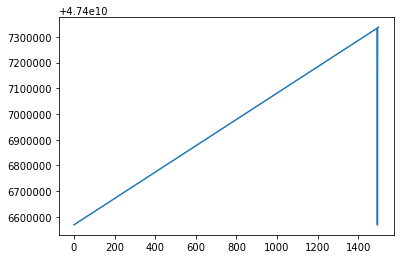

In [120]:
plt.plot( [ele.gpudata for ele in J_History])

Denny Britz's way:  

http://www.wildml.com/2015/09/speeding-up-your-neural-network-with-theano-and-the-gpu/

[Speeding up your Neural Network with Theano and the GPU](http://www.wildml.com/2015/09/speeding-up-your-neural-network-with-theano-and-the-gpu/)

and his jupyter notebook

https://github.com/dennybritz/nn-theano/blob/master/nn-theano-gpu.ipynb

[ `nn-theano/nn-theano-gpu.ipynb`](https://github.com/dennybritz/nn-theano/blob/master/nn-theano-gpu.ipynb)




In [73]:
input_X_linreg.shape

(97, 2)

In [122]:
# GPU NOTE: Conversion to float32 to store them on the GPU!
X = theano.shared( input_X_linreg.astype('float32'), name='X' )
y = theano.shared( y_linreg_training.astype('float32'), name='y')

In [123]:
# GPU NOTE: Conversion to float32 to store them on the GPU!  
theta = theano.shared( np.vstack(theta_0).astype("float32"), name='theta')

In [136]:
# Construct Theano "expression graph"

predicted_vals = sandbox.cuda.basic_ops.gpu_from_host( 
    T.dot(X,theta) )  # h_{\theta}
m = np.float32( y_linreg_training.shape[0] )
# cost function J_theta, J_{\theta}
J_theta = sandbox.cuda.basic_ops.gpu_from_host( 
    (
        T.dot( (T.dot(X,theta) - y).T, T.dot(X,theta) - y) * np.float32(0.5) * np.float32( 1./m)  
    ).reshape([]) )   # cost function  # reshape is to force "broadcast" into 0-dim. scalar for cost function
    


In [137]:
update_theta = sandbox.cuda.basic_ops.gpu_from_host( 
        theta - alpha * T.grad( J_theta, theta) )

In [138]:
# Note that we removed the input values because we will always use the same shared variable
# GPU Note: Removed the input values to avoid copying data to the GPU.
gradientDescent = theano.function( 
                            inputs=[],
#                            outputs=[predicted_vals,J_theta],  
                            updates=[(theta, update_theta)], 
                            name = "gradientDescent")


In [139]:
print( gradientDescent.maker.fgraph.toposort() )

[Shape_i{1}(theta), GpuDimShuffle{1,0}(X), GpuGemm{no_inplace}(y, TensorConstant{1.0}, X, theta, TensorConstant{-1.0}), MakeVector{dtype='int64'}(Shape_i{1}.0, Shape_i{1}.0), GpuReshape{2}(CudaNdarrayConstant{1.0}, MakeVector{dtype='int64'}.0), GpuElemwise{mul,no_inplace}(CudaNdarrayConstant{[[ 0.00515464]]}, GpuReshape{2}.0), GpuDot22(GpuGemm{no_inplace}.0, GpuElemwise{mul,no_inplace}.0), GpuDimShuffle{1,0}(GpuElemwise{mul,no_inplace}.0), GpuDot22(GpuGemm{no_inplace}.0, GpuDimShuffle{1,0}.0), GpuGemm{inplace}(theta, TensorConstant{-0.00999999977648}, GpuDimShuffle{1,0}.0, GpuDot22.0, TensorConstant{1.0}), GpuGemm{inplace}(GpuGemm{inplace}.0, TensorConstant{-0.00999999977648}, GpuDimShuffle{1,0}.0, GpuDot22.0, TensorConstant{1.0})]


In [141]:
#J_History = [0 for iter in range(num_iters)]
for iter in range(num_iters):
    gradientDescent( ) 
    

In [78]:
print( np.vstack( theta_0).shape )
print( y_linreg_training.shape )

(2, 1)
(97, 1)


In [149]:
theta.get_value()

array([[-3.63076854],
       [ 1.16641033]], dtype=float32)

In [152]:
# Profiling
print( theano.config.profile )  # Do the vm/cvm linkers profile the execution time of Theano functions?
print( theano.config.profile_memory ) # Do the vm/cvm linkers profile the memory usage of Theano functions? It only works when profile=True.

False
False


In [154]:
theano.printing.debugprint(gradientDescent)

GpuGemm{inplace} [id A] ''   10
 |GpuGemm{inplace} [id B] ''   9
 | |theta [id C]
 | |TensorConstant{-0.00999999977648} [id D]
 | |GpuDimShuffle{1,0} [id E] ''   1
 | | |X [id F]
 | |GpuDot22 [id G] ''   8
 | | |GpuGemm{no_inplace} [id H] ''   2
 | | | |y [id I]
 | | | |TensorConstant{1.0} [id J]
 | | | |X [id F]
 | | | |theta [id C]
 | | | |TensorConstant{-1.0} [id K]
 | | |GpuDimShuffle{1,0} [id L] ''   7
 | |   |GpuElemwise{mul,no_inplace} [id M] ''   5
 | |     |CudaNdarrayConstant{[[ 0.00515464]]} [id N]
 | |     |GpuReshape{2} [id O] ''   4
 | |       |CudaNdarrayConstant{1.0} [id P]
 | |       |MakeVector{dtype='int64'} [id Q] ''   3
 | |         |Shape_i{1} [id R] ''   0
 | |         | |theta [id C]
 | |         |Shape_i{1} [id R] ''   0
 | |TensorConstant{1.0} [id J]
 |TensorConstant{-0.00999999977648} [id D]
 |GpuDimShuffle{1,0} [id E] ''   1
 |GpuDot22 [id S] ''   6
 | |GpuGemm{no_inplace} [id H] ''   2
 | |GpuElemwise{mul,no_inplace} [id M] ''   5
 |TensorConstant{1.0} [id 

In [157]:
#print( gradientDescent.profile.print_summary() )
dir( gradientDescent.profile)

['__class__',
 '__delattr__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

## Testing the Linear Regression with (Batch) Gradient Descent classes in `./ML/`

In [8]:
import sys
import os

In [9]:
#sys.path.append( os.getcwd() + '/ML')
sys.path.append( os.getcwd() + '/ML' )

In [10]:
from linreg_gradDes import LinearReg, LinearReg_loaded
#from ML import LinearReg, LinearReg_loaded

**Boilerplate** for sample input data

In [11]:
linregdata1 = pd.read_csv('./coursera_Ng/machine-learning-ex1/ex1/ex1data1.txt', header=None)
linregdata1.as_matrix([0]).shape
linregdata1.as_matrix([1]).shape

(97, 1)

In [12]:
features = linregdata1.as_matrix([0]).shape[1]
numberoftraining = linregdata1.as_matrix([0]).shape[0]
LinReg_housing = LinearReg( features, numberoftraining , 0.01)

In [13]:
Xin   = LinReg_housing.preprocess_X( linregdata1.as_matrix([0]))
ytest = linregdata1.as_matrix([1]).flatten()

In [14]:
%time LinReg_housing.build_model( Xin, ytest )

CPU times: user 171 ms, sys: 28.9 ms, total: 200 ms
Wall time: 198 ms


array([-3.63029242,  1.1663624 ], dtype=float32)

In [19]:
LinRegloaded_housing = LinearReg_loaded( linregdata1.as_matrix([0]), linregdata1.as_matrix([1]), 
                                        features, numberoftraining )

In [20]:
%time LinRegloaded_housing.build_model()

CPU times: user 136 ms, sys: 16.4 ms, total: 152 ms
Wall time: 132 ms


array([[-3.63028979],
       [ 1.16636217]], dtype=float32)

In [53]:
print( LinReg_housing.gradientDescent.maker.fgraph.toposort() )
print( LinRegloaded_housing.gradientDescent.maker.fgraph.toposort() )


[GpuFromHost(X), Shape_i{0}(X), GpuFromHost(y), GpuAllocEmpty(TensorConstant{1}), GpuDimShuffle{1,0}(GpuFromHost.0), GpuAllocEmpty(Shape_i{0}.0), GpuGemv{inplace}(GpuAllocEmpty.0, TensorConstant{1.0}, GpuFromHost.0, theta, TensorConstant{0.0}), GpuElemwise{Sub}[(0, 1)](GpuGemv{inplace}.0, GpuFromHost.0), GpuDimShuffle{0}(GpuElemwise{Sub}[(0, 1)].0), GpuDimShuffle{x,0}(GpuElemwise{Sub}[(0, 1)].0), GpuGemv{inplace}(GpuAllocEmpty.0, TensorConstant{1.0}, GpuDimShuffle{x,0}.0, GpuDimShuffle{0}.0, TensorConstant{0.0}), GpuElemwise{Mul}[(0, 1)](CudaNdarrayConstant{[ 0.00515464]}, GpuElemwise{Sub}[(0, 1)].0), GpuDimShuffle{}(GpuGemv{inplace}.0), GpuGemv{inplace}(theta, TensorConstant{-0.019999999553}, GpuDimShuffle{1,0}.0, GpuElemwise{Mul}[(0, 1)].0, TensorConstant{1.0}), GpuElemwise{Mul}[(0, 1)](CudaNdarrayConstant{0.00515463901684}, GpuDimShuffle{}.0)]
[Shape_i{1}(theta), GpuDimShuffle{1,0}(X), GpuGemm{no_inplace}(y, TensorConstant{1.0}, X, theta, TensorConstant{-1.0}), MakeVector{dtype='int

#### Other (sample) datasets

Consider *feature normalization*

In [40]:
def featureNormalize(X):
    """
    FEATURENORMALIZE Normalizes the features in X  
    FEATURENORMALIZE(X) returns a normalized version of X where  
    the mean value of each feature is 0 and the standard deviation  
    is 1.  This is often a good preprocessing step to do when 
    working with learning algorithms.
    
    """
    # You need to set these values correctly  
    X_norm = (X-X.mean(axis=0))/X.std(axis=0)
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    
    return [X_norm, mu, sigma]

In [41]:
linregdata2 = pd.read_csv('./coursera_Ng/machine-learning-ex1/ex1/ex1data2.txt', header=None)


In [42]:
features = linregdata2.as_matrix().shape[1] - 1
numberoftraining = linregdata2.as_matrix().shape[0]
Xdat  = linregdata2.as_matrix( range(features) )
ytest = linregdata2.as_matrix( [features])

In [46]:
[Xnorm, mus,sigmas] = featureNormalize(Xdat)

In [48]:
LinReg_housing2 = LinearReg( features, numberoftraining, 0.01)
processed_X = LinReg_housing2.preprocess_X( Xnorm )

In [49]:
%time LinReg_housing2.build_model( processed_X, ytest.flatten(), 400)

CPU times: user 59.1 ms, sys: 8.88 ms, total: 67.9 ms
Wall time: 66.2 ms


array([ 334302.125    ,   99411.4609375,    3267.0065918], dtype=float32)

In [50]:
LinRegloaded_housing2 = LinearReg_loaded( Xnorm, ytest, 
                                        features, numberoftraining )

In [51]:
%time LinRegloaded_housing2.build_model(  400)

CPU times: user 48.9 ms, sys: 2.49 ms, total: 51.3 ms
Wall time: 45.4 ms


array([[ 334302.21875   ],
       [  99411.453125  ],
       [   3267.00976562]], dtype=float32)

##### Diabetes data from `sklearn`, sci-kit learn

In [54]:
# Load the diabetes dataset
diabetes = sklearn.datasets.load_diabetes()

In [55]:
diabetes_X = diabetes.data
diabetes_Y = diabetes.target

In [61]:
#diabetes_X1 = diabetes_X[:,np.newaxis,2]
diabetes_X1 = diabetes_X[:,np.newaxis, 2].astype(theano.config.floatX)
#diabetes_Y  = diabetes_Y.reshape( diabetes_Y.shape[0], 1)
diabetes_Y = np.vstack( diabetes_Y.astype(theano.config.floatX) )

In [63]:
features1 = 1 
numberoftraining = diabetes_Y.shape[0]

In [67]:
LinReg_diabetes = LinearReg( features1, numberoftraining, 0.01)


In [70]:
processed_X = LinReg_diabetes.preprocess_X( diabetes_X1 )

In [71]:
%time LinReg_diabetes.build_model( processed_X, diabetes_Y.flatten(), 10000)

CPU times: user 753 ms, sys: 118 ms, total: 871 ms
Wall time: 867 ms


array([ 152.13273621,  192.24055481], dtype=float32)

In [74]:
LinRegloaded_diabetes = LinearReg_loaded( diabetes_X1, diabetes_Y, 
                                        features1, numberoftraining )

In [75]:
%time LinRegloaded_diabetes.build_model(  10000)

CPU times: user 707 ms, sys: 45.2 ms, total: 752 ms
Wall time: 718 ms


array([[ 152.13198853],
       [ 192.2406311 ]], dtype=float32)

Multiple number of features case:

In [76]:
features = diabetes_X.shape[1]


In [77]:
LinReg_diabetes = LinearReg( features, numberoftraining, 0.01)
processed_X = LinReg_diabetes.preprocess_X( diabetes_X )

In [78]:
%time LinReg_diabetes.build_model( processed_X, diabetes_Y.flatten(), 10000)

CPU times: user 855 ms, sys: 113 ms, total: 968 ms
Wall time: 964 ms


array([ 152.13273621,   40.02508163,   -5.81352949,  162.25823975,
        117.35097504,   38.3995285 ,   24.88706589, -100.40937042,
         99.55418396,  149.29826355,   92.1962738 ], dtype=float32)

In [79]:
LinRegloaded_diabetes = LinearReg_loaded( diabetes_X, diabetes_Y, 
                                        features, numberoftraining )

In [80]:
%time LinRegloaded_diabetes.build_model(  10000)

CPU times: user 702 ms, sys: 64.4 ms, total: 766 ms
Wall time: 728 ms


array([[ 152.13198853],
       [  40.02506256],
       [  -5.81354237],
       [ 162.25799561],
       [ 117.35108948],
       [  38.39954376],
       [  24.88703156],
       [-100.40942383],
       [  99.55430603],
       [ 149.29826355],
       [  92.1962738 ]], dtype=float32)

# Multi-class Classification 

cf. `ex3`, Programming Exercise 3: Multi-class Classification and Neural Networks, Machine Learning

## 1 Multi-class Classification

In [83]:
os.getcwd()

'/home/topolo/PropD/MLgrabbag'

In [86]:
os.listdir( './coursera_Ng/machine-learning-ex3/' )

['ex3.pdf', 'ex3']

In [87]:
os.listdir( './coursera_Ng/machine-learning-ex3/ex3' )

['ex3data1.mat',
 'submit.m',
 'sigmoid.m',
 'lrCostFunction.m',
 'predictOneVsAll.m',
 'oneVsAll.m',
 'predict.m',
 'ex3.m',
 'lib',
 'displayData.m',
 'ex3_nn.m',
 'fmincg.m',
 'ex3weights.mat']

In [90]:
# Load saved matrices from file 
multiclscls_data = scipy.io.loadmat('./coursera_Ng/machine-learning-ex3/ex3/ex3data1.mat')

import the classes from `ML`


In [9]:
import sys
import os

In [9]:
os.getcwd()

'/home/topolo/PropD/MLgrabbag'

In [10]:
#sys.path.append( os.getcwd() + '/ML')
sys.path.append( os.getcwd() + '/ML' )

In [11]:
from gradDes import LogReg

In [12]:
# Test case for Cost function J_{\theta} with regularization

theta_t = np.vstack( np.array( [-2, -1, 1, 2]) )
X_t = np.array( [i/10. for i in range(1,16)]).reshape((3,5)).T
#X_t = np.hstack( ( np.ones((5,1)), X_t) ) # no need to preprocess the input data X with column of 1's
y_t = np.vstack( np.array( [1,0,1,0,1]))


In [13]:
MulClsCls_digits = LogReg( X_t, y_t, 3,5,0.01, 3.  )

In [14]:
MulClsCls_digits.calculate_cost()

CudaNdarray(0.125)

In [19]:
MulClsCls_digits.z.get_value()

AttributeError: 'CudaNdarrayVariable' object has no attribute 'get_value'

In [21]:
print( MulClsCls_digits.X.get_value() )
MulClsCls_digits.y.get_value()

[[ 1.          0.1         0.60000002  1.10000002]
 [ 1.          0.2         0.69999999  1.20000005]
 [ 1.          0.30000001  0.80000001  1.29999995]
 [ 1.          0.40000001  0.89999998  1.39999998]
 [ 1.          0.5         1.          1.5       ]]


array([[ 1.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.]], dtype=float32)

In [23]:
calc_z_test = theano.function([], MulClsCls_digits.z)

In [24]:
calc_z_test()

CudaNdarray([[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]])

In [25]:
MulClsCls_digits.theta.set_value( theta_t.astype('float32') )

In [27]:
calc_z_test()

CudaNdarray([[ 0.70000017]
 [ 0.9000001 ]
 [ 1.0999999 ]
 [ 1.29999983]
 [ 1.5       ]])

In [35]:
MulClsCls_digits.calculate_cost()

CudaNdarray(1.93287348747)

In [43]:
print( 1/(1+np.exp( np.dot( -np.hstack( ( np.ones((5,1)), X_t) ), theta_t) ) )  )
h_test = 1/(1+np.exp( np.dot( -np.hstack( ( np.ones((5,1)), X_t) ), theta_t) ) ) 
print( np.dot( (h_test - y_t).T, h_test- y_t) * 0.5/5 ) # non-regularized J_theta cost term
np.dot( theta_t[1:].T, theta_t[1:]) * 3 / (2.* 5)


[[ 0.66818777]
 [ 0.7109495 ]
 [ 0.75026011]
 [ 0.78583498]
 [ 0.81757448]]
[[ 0.13287343]]


array([[ 1.8]])

In [33]:
MulClsCls_digits.predict()

array([[ 0.66818786],
       [ 0.71094954],
       [ 0.75026011],
       [ 0.78583503],
       [ 0.81757444]], dtype=float32)

In [ ]:
MulClsCls_digit

In [44]:
theano.config.floatX

'float32'

# Neural Networks

## Model representation

cf. 2 Neural Networks, 2.1 Model representation, `ex3.pdf`

In [45]:
os.getcwd()

'/home/topolo/PropD/MLgrabbag'

In [46]:
os.listdir( './coursera_Ng/machine-learning-ex3/' )

['ex3.pdf', 'ex3']

In [47]:
os.listdir( './coursera_Ng/machine-learning-ex3/ex3/' )

['ex3data1.mat',
 'submit.m',
 'sigmoid.m',
 'token.mat',
 'lrCostFunction.m',
 'predictOneVsAll.m',
 'oneVsAll.m',
 'predict.m',
 'ex3.m',
 'lib',
 'displayData.m',
 'ex3_nn.m',
 'fmincg.m',
 'ex3weights.mat']

$ \Theta_1, \Theta_2 $

In [48]:
# Load saved matrices from file 
nn3_data = scipy.io.loadmat('./coursera_Ng/machine-learning-ex3/ex3/ex3weights.mat')

In [53]:
print( nn3_data.keys() )
print( type( nn3_data['Theta1']) )
print( type( nn3_data['Theta2']) )
print( nn3_data['Theta1'].shape )
print( nn3_data['Theta2'].shape )

['Theta2', '__version__', '__header__', 'Theta1', '__globals__']
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
(25, 401)
(10, 26)
